# Problem 1. Model inference with graphical model

A graphical model provides a visual overview of inderdepedency structures of random variables to compactly represent their joint distribution.

In this problem, your task is to discover the model of data generating process for the following graphical model. Before proceeding, see "Graphical model" part of "Going Bayesian" section notebook for review of notations.

In [25]:
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import daft
import matplotlib.pyplot as plt

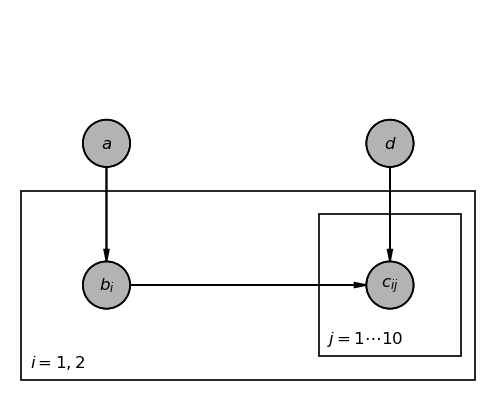

In [2]:
pgm = daft.PGM(shape=(5,4))

# Add nodes
pgm.add_node(daft.Node("a", r"$a$", 1, 3.5, observed=True))
pgm.add_node(daft.Node("b_i", r"$b_i$", 1, 2, observed=True))
pgm.add_node(daft.Node("c_ij", r"$c_{ij}$", 4, 2, observed=True))
pgm.add_node(daft.Node("d", r"$d$", 4, 3.5, observed=True))

# Add in the edges
pgm.add_edge("a", "b_i")
pgm.add_edge("b_i", "c_ij")
pgm.add_edge("d", "c_ij")

# Add a plate
pgm.add_plate(daft.Plate([3.25, 1.25, 1.5, 1.5], label=r'$j=1 \cdots 10$'))
pgm.add_plate(daft.Plate([0.1, 1, 4.8, 2], label=r'$i=1, 2$'))


# Render an image
pgm.render()
pgm.figure.dpi = 120

### (a): Write down the factored expression of *joint* distribution specified by this graphical model.

***Your answer here:***

$P(a,b_i,c_{i,j},d)=P(c_{i,j}|b_i,d)P(b_i|a)P(a,d)$

Random variables in this model are drawn from `Normal`, `Exponential`, `Gamma`, and `Beta` distributions, but we are not telling you which random variabble is drawn from which. So, you will have to define `JointDistribution` model with different permutations of distributions, optimize the model parameter via MLE, and choose the model with the largest data likelihood. 

Here is an example to help you get started.

### Neal's funnel

$p(x,y,z)=\mathcal{N}(z|-1.5, 3) \ \mathcal{N}(x|0, \exp(z/4))\ \mathcal{N}(x|0, 1.2\exp(z/4))$


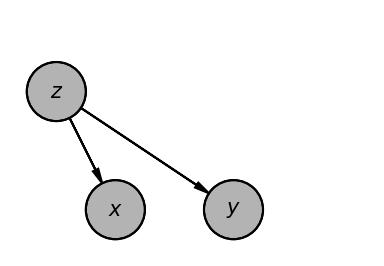

In [3]:
pgm = daft.PGM(shape=(3,2))

# Add nodes
pgm.add_node(daft.Node("z", r"$z$", 1, 1.5, observed=True))
pgm.add_node(daft.Node("x", r"$x$", 1.5, 0.5, observed=True))
pgm.add_node(daft.Node("y", r"$y$", 2.5, 0.5, observed=True))

# Add in the edges
pgm.add_edge("z", "x")
pgm.add_edge("z", "y")

# Render an image
pgm.render()
pgm.figure.dpi = 150

You can specify variable name using `JointDistributionNamed` class.

In [4]:
# Joint distribution of Neal's funnel
joint = tfd.JointDistributionNamed(dict(
    z=          tfd.Normal(loc=-1.5, scale=3.), 
    x=lambda z: tfd.Normal(loc=0., scale=tf.exp(z/4)), 
    y=lambda z: tfd.Normal(loc=0., scale=1.2*tf.exp(z/4)), 
))

joint.sample(1000).keys()

dict_keys(['z', 'y', 'x'])

**Hint**: When defining the dependency of $c$ on $b$, you will obtain two sets of random variable $c$'s (i.e., $c_{1j}$ and $c_{2j}$). You can tell Tensorflow probability to interpret these as a single random varialbe with `Independent` distribution class. Here is an example:

In [5]:
# two independent random variables
rv1 = tfd.Normal(loc=-1., scale=0.1)
rv2 = tfd.Normal(loc=1., scale=0.5)

# single random variable
rv = tfd.Independent(
    distribution=tfd.Normal(loc=[-1., 1], scale=[0.1, 0.5])
)

rv_samples = rv.sample(100)
rv_samples.shape # this will have 2x100 dimension

TensorShape([100, 2])

Consider the following graphical model where

$\begin{align*}
  a &\sim \text{Beta}(a|5, 5) \\
  b_i &\sim \text{Exp}(b_i|3) \\
  c_{ij} &\sim \text{LogNormal}(c_{ij}|b_i, a) \\
  \end{align*}$

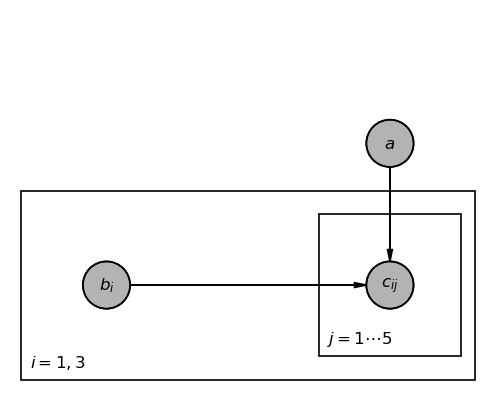

In [6]:
pgm = daft.PGM(shape=(5,4))

# Add nodes
pgm.add_node(daft.Node("b_i", r"$b_i$", 1, 2, observed=True))
pgm.add_node(daft.Node("c_ij", r"$c_{ij}$", 4, 2, observed=True))
pgm.add_node(daft.Node("a", r"$a$", 4, 3.5, observed=True))

# Add in the edges
pgm.add_edge("b_i", "c_ij")
pgm.add_edge("a", "c_ij")

# Add a plate
pgm.add_plate(daft.Plate([3.25, 1.25, 1.5, 1.5], label=r'$j=1 \cdots 5$'))
pgm.add_plate(daft.Plate([0.1, 1, 4.8, 2], label=r'$i=1, 3$'))


# Render an image
pgm.render()
pgm.figure.dpi = 120

Following codes show how we can use `Independent` and `Sample` classes to represent $b_i$ and $c_{ij}$ inside the plates. 

In [7]:
joint = tfd.JointDistributionNamed(dict(
    # a
    a = tfd.Beta(5, 5),

    # we sample b thrice using "Sample" 
    b_i = tfd.Sample(
        distribution=tfd.Exponential(3), 
        sample_shape=3,
    ),

    # and use these b's for the mean of LogNormal c
    c_ij = lambda a, b_i: tfd.Sample(
        distribution=tfd.LogNormal(loc=b_i, scale=tf.transpose([a, a, a])),
        sample_shape=5,   
    )
))

samples = joint.sample(100)
for rv_name, rv_sample in samples.items():
    print(rv_name, rv_sample.shape)

b_i (100, 3)
a (100,)
c_ij (100, 3, 5)


Following code seems to be working, but if you try to evaluate `log_prob`...

In [8]:
#tf.reduce_mean(joint.log_prob(samples))

We see this error because there are three independent sets of $c$'s, and our `joint` doesn't see them as different realizatation of one random variable. We can fix this by making `LogNormal` as `Indendent` distribution as follow.

In [9]:
joint_with_independent_LogNormal = tfd.JointDistributionNamed(dict(
    # a
    a = tfd.Beta(5, 5),

    # we sample b thrice using "Sample" 
    b_i = tfd.Sample(
        distribution=tfd.Exponential(3), 
        sample_shape=3,
    ),

    # and use these b's for the mean of LogNormal c
    c_ij = lambda a, b_i: tfd.Independent(
        tfd.Sample(distribution=tfd.LogNormal(loc=b_i, scale=tf.transpose([a, a, a])),
                  sample_shape=5,
        )   
    )
))

tf.reduce_mean(joint_with_independent_LogNormal.log_prob(samples))

<tf.Tensor: shape=(), dtype=float32, numpy=-14.001047>

### (b). Infer this model! 

Once you decide on your model, generate 10,000 samples from your model, [pickle](https://wiki.python.org/moin/UsingPickle) them, and **upload it on Canvas** (We won't use Kaggle this week).

In [89]:
# Read in the data and visualize
data = np.load('np_samples.pickle', allow_pickle=True)
print('RV1 shape:', data['rv1s'].shape)
print('RV2 shape:', data['rv2s'].shape)
print('RV3 shape:', data['rv3s'].shape)
print('RV4 shape:', data['rv4s'].shape)

rv1_data = data['rv1s']
rv2_data = data['rv2s']
rv3_data = data['rv3s']
rv4_data = data['rv4s']

RV1 shape: (10000,)
RV2 shape: (10000, 2)
RV3 shape: (10000,)
RV4 shape: (10000, 2, 10)


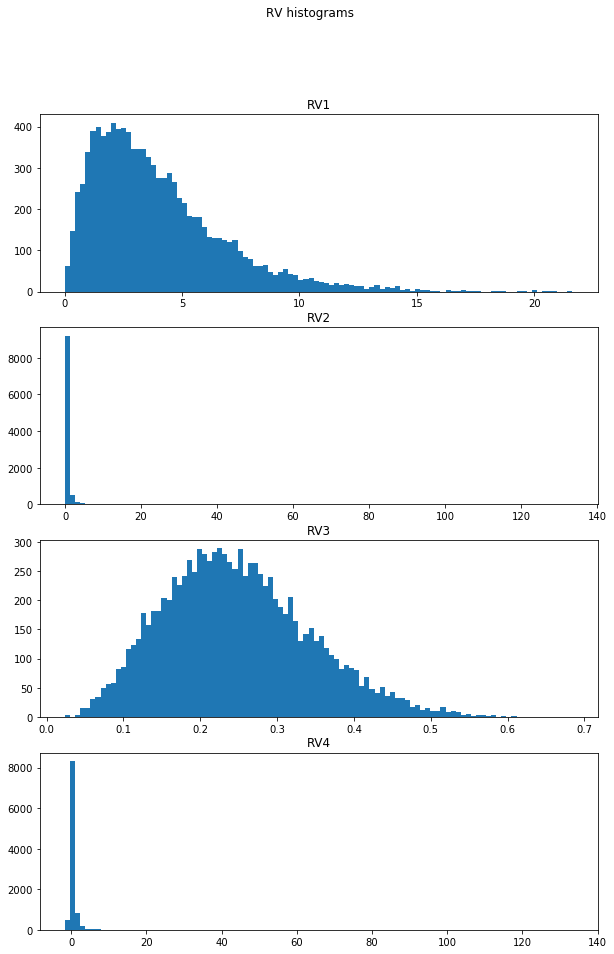

In [90]:
fig, ax = plt.subplots(4, figsize=(10,15))
fig.suptitle('RV histograms')
ax[0].hist(data['rv1s'], bins=100)
ax[0].set_title('RV1')
ax[1].hist(data['rv2s'][:,0], bins=100)
ax[1].set_title('RV2')
ax[2].hist(data['rv3s'], bins=100)
ax[2].set_title('RV3')
ax[3].hist(data['rv4s'][:,0,2], bins=100)
ax[3].set_title('RV4')
plt.show()

Looking at the shapes of the data, we can see that RV1 and RV3 are $a$ and $d$, though we don't know which is which. We also know that RV2 is $b$ and RV4 is $c$. $a$ looks like it could either be Gamma or Beta distributed, while $d$ could be also be Gamma or Beta. $c$ has negative values, and since none of the other distributions do, this must mean that $c$ is normally distributed. Finally, that leaves $b$ as the exponentially distributed variable. Therefore, we have four model structures that we can test. However, we can take a short cut by checking whether RV2 is strongly coorelated with RV1 or RV3, which would give us a hint as to which is more likely to be $a$. Checking below...

In [108]:
corr_1_0 = tfp.stats.correlation(rv2_data[:,0], rv1_data, sample_axis=0, event_axis=None)
corr_1_1 = tfp.stats.correlation(rv2_data[:,1], rv1_data, sample_axis=0, event_axis=None)

corr_3_0 = tfp.stats.correlation(rv2_data[:,0], rv3_data, sample_axis=0, event_axis=None)
corr_3_1 = tfp.stats.correlation(rv2_data[:,1], rv3_data, sample_axis=0, event_axis=None)

tf.print('Mean corr of RV2 with RV1:', tf.reduce_mean([corr_1_0, corr_1_1]))
tf.print('Mean corr of RV2 with RV3:', tf.reduce_mean([corr_3_0, corr_3_1]))

Mean corr of RV2 with RV1: -0.21670346
Mean corr of RV2 with RV3: 0.00338922418


Looking at the coorelations, we can see that RV1 is much more likely to be $a$ than RV3. So know we have uncovered the structure of the graph, and only have to detirmine whether $a$ is Gamma or Beta distributed (which will immediatly tell us about b). However, we still don't know *how* the random variables are related. For example, how is the output of $a$ incorporated into $b$? Well the correlation is negative, meaning that hgiher values of $b$ are associated with lower values of $a$ and vice-versa. Let's look at what happends when we multiply $a\times b$, if $b$ is using $a$ as its rate parameter, then we would expect to see the mean of the resulting values to be 1. Checking below...

In [121]:
a_times_b = tf.stack([tf.multiply(rv2_data[:,0], rv1_data), tf.multiply(rv2_data[:,1], rv1_data)])
tf.print("Mean:", tf.reduce_mean(a_times_b))

Mean: 1.00703228


This is indeed what we see, so we have strong evidence that $b$ takes its rate parameter from the output of $a$. Next, we want to test how $c$ is connected to $b$ and $d$. We can see if $c$ takes one of these in as a its location parameter and the other as its scale parameter. To test if $d$ or $b$ is the mean of $c$, we can subtract each from $c$ and see if we get a vector of values centered around 0. Similarly, dividing $c$ by $d$ or $b$ tells us if either is being used as the scale parameter if the resulting vector has a standard deviation of 1. Doing this below..

In [143]:
c_minus_d = rv4_data[:,0,0]-rv3_data
c_minus_b = rv4_data[:,0,0]-rv2_data[:,0]

# might want to make one model that takes 1/9 of this
c_dividedby_d = c_minus_d/rv3_data
c_dividedby_b = c_minus_b/rv2_data[:,0]

tf.print('c minus d mean:', tf.reduce_mean(c_minus_d))
tf.print('c minus b mean:', tf.reduce_mean(c_minus_b))
print()
tf.print('c divided by d std:', tf.math.reduce_std(c_dividedby_d))
tf.print('c divided by b std:', tf.math.reduce_std(c_dividedby_b))

c minus d mean: 0.282194227
c minus b mean: 0.00132942584

c divided by d std: 9.30062866
c divided by b std: 811.51178


In [ ]:
Looking at the above outputs, it look

In [127]:
tf.reduce_mean(c_minus_b)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0013294258>

In [118]:
tf.reduce_mean(tf.multiply(rv2_data[:,0], rv1_data))


<tf.Tensor: shape=(), dtype=float32, numpy=1.0113884>

In [117]:
tf.reduce_mean(rv2_data)

<tf.Tensor: shape=(), dtype=float32, numpy=0.52384955>

In [ ]:
def get_distribution(z_mean, z_var, x_a, x_b, y_a, y_b):
  guess_sum_of_distributions = tfd.JointDistributionNamed(dict(
      z=tfd.Normal(loc=z_mean, scale=z_var),
      x= lambda z: tfd.Normal(loc=0., scale=x_a*tf.exp(z/x_b)),
      y= lambda z: tfd.Normal(loc=0., scale=y_a*tf.exp(z/y_b)),
  ))
  return guess_sum_of_distributions

def get_loss(a,b,c,d,e,f):
  guess = get_distribution(a,b,c,d,e,f)
  return tf.reduce_mean(guess.log_prob(tf_samples))


joint_with_independent_LogNormal = tfd.JointDistributionNamed(dict(
    # a
    a = tfd.Beta(5, 5),

    # we sample b thrice using "Sample" 
    b_i = tfd.Sample(
        distribution=tfd.Exponential(3), 
        sample_shape=3,
    ),

    # and use these b's for the mean of LogNormal c
    c_ij = lambda a, b_i: tfd.Independent(
        tfd.Sample(distribution=tfd.LogNormal(loc=b_i, scale=tf.transpose([a, a, a])),
                  sample_shape=5,
        )   
    )
))

tf.reduce_mean(joint_with_independent_LogNormal.log_prob(samples))

In [161]:
norm_dist = lambda loc, scale: tfd.Normal(loc=loc, scale=scale)
expo_dist = lambda rate: tfd.Exponential(rate=rate)
gamma_dist = lambda alpha, beta: tfd.Gamma(concentration=alpha, rate=beta)
beta_dist = lambda alpha, beta: tfd.Beta(concentration1=alpha, concentration0=beta)

# RV1 is a and Beta => RV3 is d and Gamma
def model_dist_1(a_params, d_params):
    est_dist = tfd.JointDistributionNamed(dict( 
        a = beta_dist(a_params[0], a_params[1]),
        d = gamma_dist(d_params[0], d_params[1]),
        b_i = lambda a: tfd.Sample(distribution=expo_dist(a), sample_shape=(2)), # don't use Independent since only 1 param
        c_ij = lambda b_i, d: tfd.Independent(tfd.Sample(distribution=norm_dist(b_i, tf.transpose(10*[d])), 
                                                      sample_shape=(2,10))
                                          )       
        ))
    return est_dist

test = model_dist_1(a_params=[1,1], d_params=[1,1])
test.log_prob(data)
#tf.reduce_mean(test.log_prob(data))
    
    
# # RV1 is a and Gamma => RV3 is d and Beta
# def model_dist_2(a_params, b_params, c_params, d_params):
    

# # def get_distribution(norm_params, expo_params, gamma_params, beta_params):
# #     est_dist = tfd.JointDistributionNamed(dict(
# #     ))

ValueError: Arguments `loc` and `scale` must have compatible shapes; loc.shape=(2,), scale.shape=(10,).

In [153]:
beta_dist(1, 1).sample()

<tf.Tensor: shape=(), dtype=float32, numpy=0.13178419>

In [83]:
# corr[i, j] is the sample correlation between x[:, i, j] and y[:, i, j].
corr = tfp.stats.correlation(x, y, sample_axis=0, event_axis=None)

# corr_matrix[i, m, n] is the sample correlation of x[:, i, m] and y[:, i, n]
corr_matrix = tfp.stats.correlation(x, y, sample_axis=0, event_axis=-1)


In [85]:
corr

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 0.02286513, -0.15181404,  0.06636407],
       [-0.02835085, -0.04497292, -0.1897917 ]], dtype=float32)>